# Toxicity Detection Model

Get live data with `get_comments.py` and transform Kaggle data set with `transform_train.py`

Get libraries by running `pip install -r requirements.txt`

This is a deep learning model.

In [48]:
# # import tensorflow as tf
# import keras
# from keras import layers
import numpy as np
import pandas as pd


import matplotlib.pyplot as plt
import seaborn as sns

from wordcloud import STOPWORDS, wordcloud
import re
from fuzzywuzzy import fuzz, process

from tqdm import tqdm

# Load Dataset

In [49]:
df_train = pd.read_csv('./data/new_train.csv')

### Data Cleansing
<ul>
    <li>Removal of special characters</li>
    <li>Expanding contractions</li>
    <li>Lowering text</li>
    <li>Replacing Obfuscated Profane Words</li>
</ul>

In [50]:
def decontracted(phrase):
    '''
    This function decontracts words like won't to will not
    '''

    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    
    return phrase

In [51]:
def removeNonPrintable(com):
    com = com.replace('\\r', ' ')
    com = com.replace('\\n', ' ')
    com = com.replace('\\t', ' ')
    com = com.replace('\\"', ' ')
    return com

In [52]:
def getUniqueWords(comments):
    unique_words = set()
    for comment in tqdm(comments):
        words = comment.split(" ")
        for word in words:
            if len(word) > 2:
                unique_words.add(word)
    
    return unique_words

In [53]:
def getProfaneWords():
    profane_words = []
    with open("./data/bad-words.txt","r") as f:
        for word in f:
            word = word.replace("\n","")
            profane_words.append(word)
    return profane_words
    

In [54]:
def createMappingDict(profane_words, unique_words):
    # mapping dictionary
    mapping_dict = dict()
    
    # looping through each profane word
    for profane in tqdm(profane_words):
        mapped_words = set()
        
        # looping through each word in vocab
        for word in unique_words:
            # mapping only if ratio > 80
            try:
                if fuzz.ratio(profane,word) > 80:
                    mapped_words.add(word)
            except:
                pass
                
        # list of all vocab words for given profane word
        mapping_dict[profane] = mapped_words
    
    return mapping_dict

In [55]:
def replaceWords(corpus, mapping_dict):
    processed_corpus = []

    for document in tqdm(corpus):

        # words = document.split()

        for mapped_word, v in mapping_dict.items():
            
            document = re.sub(r'\b{word}\b'.format(word = v), mapped_word, document)

            # for target_word in v:

            #     for i, word in enumerate(words):
            #         if word == target_word:
            #             words[i] = mapped_word

        # document = " ".join(words)
        document = document.strip()

        processed_corpus.append(document)

    return processed_corpus



In [56]:
def final_processing(corpus):
    '''
    Function applies final processing steps post profane mapping such as removing special characters,
    punctuations etc.
    '''
    processed_comments = []
    print('final_processing')

    emoj = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)


    # looping through each comment in corpus
    for comment in tqdm(corpus):
        try:
          processed_words = []
          comment = re.sub(emoj, r'', comment)
          comment = re.sub(r'http\S+', '', comment)
          # comment = re.sub("\B\#\w+", ' ', comment)
          # comment = re.sub("\B\@\w+", '', comment)
          comment = re.sub(r'(\w*#\w+|\w+#\w*)','', comment)
          comment = re.sub(r'(\w*@\w+|\w+#\w*)','',  comment)
          comment = re.sub(r'[^A-Za-z\s]+',"",  comment) # retain only letters
          for word in comment.split():
              if len(word) >= 3:
                  processed_words.append(word)
              
          comment = " ".join(processed_words)
          
          processed_comments.append(comment.strip())
        except Exception as e:
          print(corpus)
          print(e)
          pass
    
    return processed_comments

In [57]:
def cleanComments(comments):
    processed_comments = []
    for comment in comments:
        comment = decontracted(comment)
        comment = removeNonPrintable(comment)

        # Lower comment
        processed_comments.append(comment.lower().strip())
      
    profane_words = getProfaneWords()
    #unique_words = getUniqueWords(processed_comments)
    #profane_dict = createMappingDict(profane_words, unique_words)
    #processed_comments = replaceWords(processed_comments, profane_dict)
    final_comments = final_processing(processed_comments)
    return final_comments

In [58]:
def corrHeatmap(df):
    classes = df.columns[1:]
    data = df.copy()
    data = data[classes]
    corr = data.corr()

    plt.figure(figsize=(8,6))
    sns.heatmap(corr,annot=True,vmin=1,vmax=0,fmt='.2g',cmap='rocket')
    plt.title("Correlation Matrix: Comment Labels")

    plt.show()

In [59]:
def showPercentiles(data):
    print("========== For 0-100 ==========")
    for i in range(11):
        print(f'{i*10}th Percentile Value = {np.percentile(data, i*10)}')

    print("\n")
    print("========== For 90-100 ==========")
    for i in range(11):
        print(f'{90+i}th Percentile Value = {np.percentile(data, 90 + i)}')

In [60]:
def plotHist(data, bin_size, columns = None):
    if columns is not None:
        fig, axis = plt.subplots(len(columns)-1, 1, figsize = (12,30))
        for i, col in enumerate(columns[1:]):
            sns.histplot(data=data[col],bins=bin_size,palette="rocket",ax = axis[i])
    else:
        sns.histplot(data=data,bins=bin_size,palette="rocket")
    plt.show()

In [61]:
df_train.shape

(132291, 7)

In [62]:
df_train.head()

,Comment,Toxicity,Severe_Toxicity,Identity_Attack,Insult,Profanity,Threat
0,Explanation\nWhy the edits made under my usern...,0.129533,0.005232,0.009843,0.000779,0.000911,0.009409
1,D'aww! He matches this background colour I'm s...,0.022352,0.001590,0.010376,0.001265,0.001273,0.009809
2,"Hey man, I'm really not trying to edit war. It...",0.168278,0.004964,0.010698,0.004839,0.001866,0.009920
3,"""\nMore\nI can't make any real suggestions on ...",0.056532,0.002854,0.009954,0.001283,0.001134,0.009656
4,"You, sir, are my hero. Any chance you remember...",0.022491,0.002081,0.012285,0.004179,0.003558,0.011320


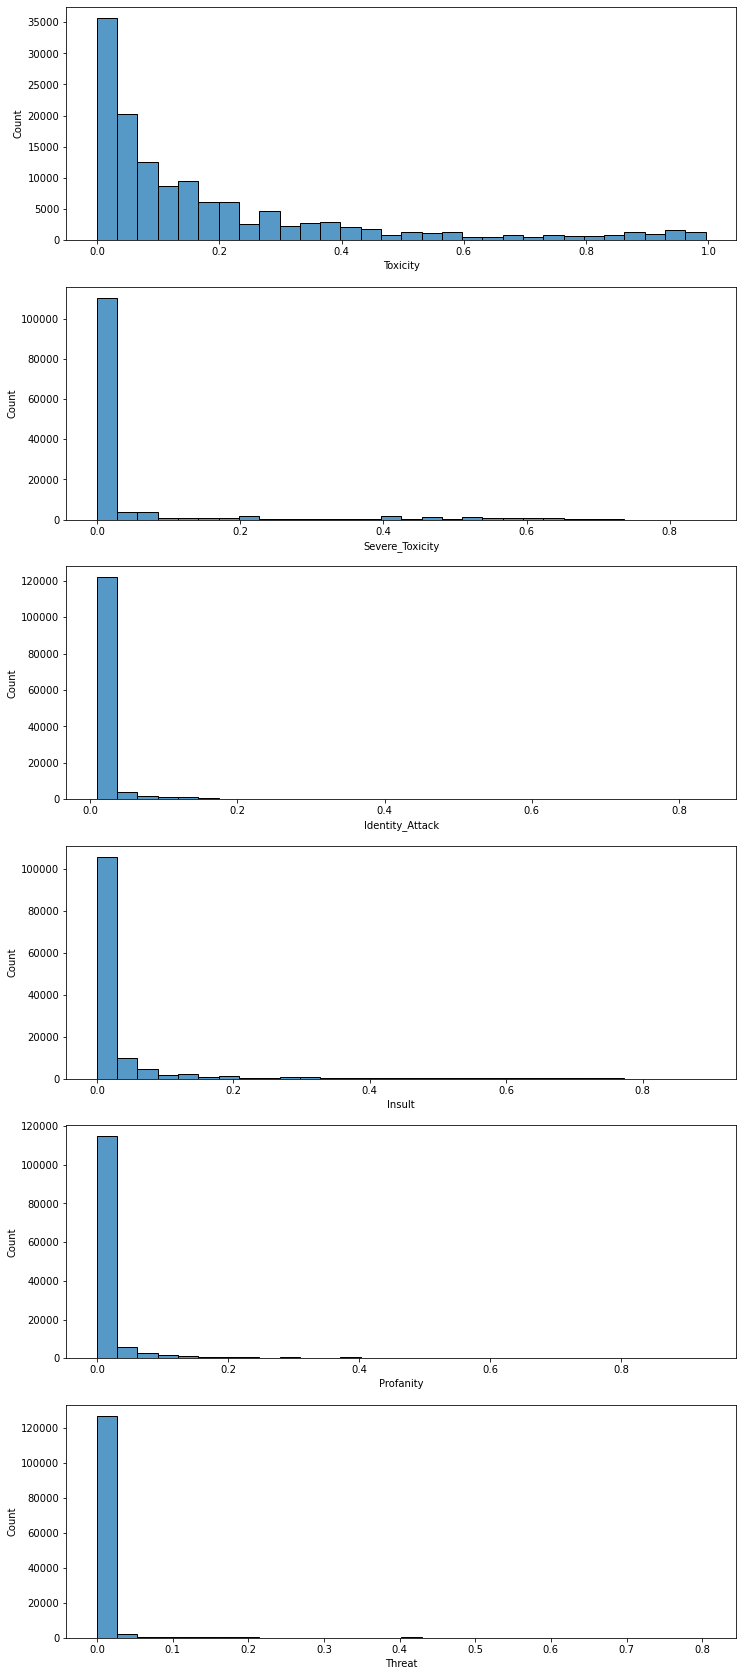

In [63]:
plotHist(df_train, 30, df_train.columns)

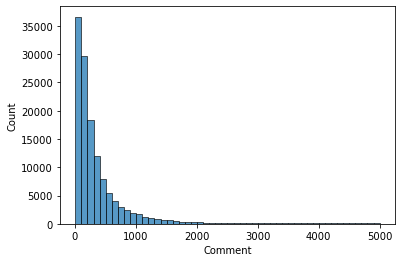

In [64]:
plotHist(df_train.Comment.str.len(), 50)

In [65]:
for cat in df_train.columns[1:]:
    print(f"============== {cat} ==============")
    showPercentiles(df_train[cat])
    print("\n")

============== Toxicity ==============
========== For 0-100 ==========
0th Percentile Value = 6.778911e-08
10th Percentile Value = 0.016173938
20th Percentile Value = 0.024490505
30th Percentile Value = 0.03770977
40th Percentile Value = 0.059328925
50th Percentile Value = 0.09333697
60th Percentile Value = 0.14104263
70th Percentile Value = 0.19936113
80th Percentile Value = 0.29855597
90th Percentile Value = 0.5038962
100th Percentile Value = 0.9953412


========== For 90-100 ==========
90th Percentile Value = 0.5038962
91th Percentile Value = 0.5535644000000001
92th Percentile Value = 0.5958905
93th Percentile Value = 0.6662635
94th Percentile Value = 0.73034537
95th Percentile Value = 0.78524166
96th Percentile Value = 0.8546526
97th Percentile Value = 0.89158845
98th Percentile Value = 0.93413806
99th Percentile Value = 0.9646382
100th Percentile Value = 0.9953412


============== Severe_Toxicity ==============
========== For 0-100 ==========
0th Percentile Value = 5.8056470000000

In [66]:
showPercentiles(df_train.Comment.str.len())

========== For 0-100 ==========
0th Percentile Value = 6.0
10th Percentile Value = 47.0
20th Percentile Value = 78.0
30th Percentile Value = 114.0
40th Percentile Value = 155.0
50th Percentile Value = 205.0
60th Percentile Value = 274.0
70th Percentile Value = 367.0
80th Percentile Value = 528.0
90th Percentile Value = 889.0
100th Percentile Value = 5000.0


========== For 90-100 ==========
90th Percentile Value = 889.0
91th Percentile Value = 956.0
92th Percentile Value = 1030.0
93th Percentile Value = 1107.0
94th Percentile Value = 1215.0
95th Percentile Value = 1359.0
96th Percentile Value = 1535.0
97th Percentile Value = 1819.300000000003
98th Percentile Value = 2322.199999999997
99th Percentile Value = 3442.100000000006
100th Percentile Value = 5000.0


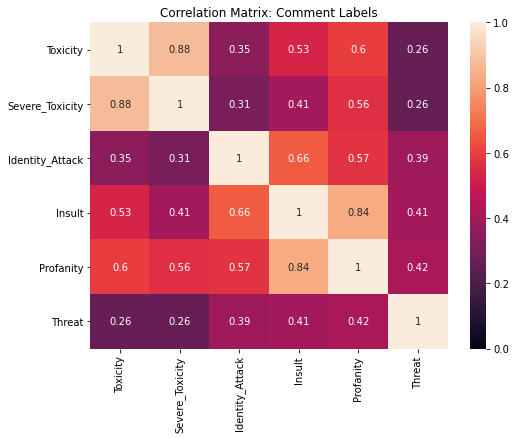

In [67]:
corrHeatmap(df_train)

In [87]:
processed_comments = cleanComments(df_train.Comment.values)

  1%|          | 754/132291 [00:00<00:17, 7470.81it/s]

final_processing


100%|██████████| 132291/132291 [00:22<00:00, 5868.40it/s]


In [89]:
df_processed = df_train[df_train.columns[1:]].copy()
df_processed['ProcessedComment'] = processed_comments

In [75]:
df_processed = pd.read_csv(r'data\new_train_10000.csv')
df_processed.drop(['Unnamed: 0'], axis = 1, inplace = True)

In [70]:
df_processed.head()

,Toxicity,Severe_Toxicity,Identity_Attack,Insult,Profanity,Threat,ProcessedComment
0,0.129533,0.005232,0.009843,0.000779,0.000911,0.009409,explanation why the edits made under username ...
1,0.022352,0.001590,0.010376,0.001265,0.001273,0.009809,daww matches this background colour seemingly ...
2,0.168278,0.004964,0.010698,0.004839,0.001866,0.009920,hey man really not trying edit war just that t...
3,0.056532,0.002854,0.009954,0.001283,0.001134,0.009656,more can not make any real suggestions improve...
4,0.022491,0.002081,0.012285,0.004179,0.003558,0.011320,you sir are hero any chance you remember what ...


In [90]:
cols = df_processed.columns.tolist()
ordered_cols = cols[-1:] + cols[:-1]
df_processed = df_processed[ordered_cols]

In [91]:
df_processed.head()

,ProcessedComment,Toxicity,Severe_Toxicity,Identity_Attack,Insult,Profanity,Threat
0,explanation why the edits made under username ...,0.129533,0.005232,0.009843,0.000779,0.000911,0.009409
1,daww matches this background colour seemingly ...,0.022352,0.001590,0.010376,0.001265,0.001273,0.009809
2,hey man really not trying edit war just that t...,0.168278,0.004964,0.010698,0.004839,0.001866,0.009920
3,more can not make any real suggestions improve...,0.056532,0.002854,0.009954,0.001283,0.001134,0.009656
4,you sir are hero any chance you remember what ...,0.022491,0.002081,0.012285,0.004179,0.003558,0.011320


In [92]:
df_processed.shape

(132291, 7)

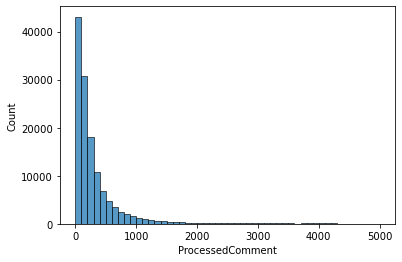

In [94]:
plotHist(df_processed.ProcessedComment.str.len(), 50)

As seen from the histogram above, the length most of the comments have is in between 0-300. Additionally, the histogram fits to logarithmic distribution and it is right-skewed. To examine the histogram furher, we can look into percentiles of the histogram to determine the vector dimensions which will be crucial for our deep learning model

In [96]:
showPercentiles(df_processed.ProcessedComment.str.len())

========== For 0-100 ==========
0th Percentile Value = 0.0
10th Percentile Value = 36.0
20th Percentile Value = 62.0
30th Percentile Value = 91.0
40th Percentile Value = 125.0
50th Percentile Value = 167.0
60th Percentile Value = 226.0
70th Percentile Value = 303.0
80th Percentile Value = 439.0
90th Percentile Value = 745.0
100th Percentile Value = 5000.0


========== For 90-100 ==========
90th Percentile Value = 745.0
91th Percentile Value = 799.0
92th Percentile Value = 866.0
93th Percentile Value = 932.0
94th Percentile Value = 1019.5999999999913
95th Percentile Value = 1137.0
96th Percentile Value = 1295.0
97th Percentile Value = 1505.0
98th Percentile Value = 1931.0
99th Percentile Value = 2847.0
100th Percentile Value = 5000.0


Almost 95% of the comments have 1000 characters approximately. As a result, the input dimension of the tokenized vectors can be 1000.

# Model Building

Turn dataset into list(list of tokens, scores x6))

In [ ]:
detections = df_train.loc[:,"Toxicity": "Threat"].__array__()[:500]
mapped = np.array([[processed_comments[i], detections[i]] for i in list(range(len(processed_comments)))], dtype=object)

In [ ]:
np.random.shuffle(mapped)

In [ ]:
train_dataset = mapped[: int(mapped.shape[0] * .9) ]
test_dataset = mapped[int(mapped.shape[0] * .9) :]

In [ ]:
BUFFER_SIZE = 1000
BATCH_SIZE = 32
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [ ]:
VOCAB_SIZE = 1000
encoder = layers.TextVectorization(max_tokens = VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

In [ ]:
model = keras.Sequential([
	encoder,
	layers.Embedding(
		input_dim = len(encoder.get_vocabulary()),
		output_dim = 64,
		# Use masking to handle the variable sequence lengths
		mask_zero = True
	),
	layers.Dropout(0.8),
	layers.Bidirectional(layers.LSTM(64)),
	layers.Dropout(0.6),
	layers.Dense(32, activation='relu'),
	layers.Dropout(0.5), # ?
	layers.Dense(6)
])

model.compile(loss = keras.losses.BinaryCrossentropy(from_logits = True),
			  optimizer = keras.optimizers.adam_v2.Adam(1e-4),
			  metrics = ['Toxicity', 'Severe_Toxicity', 'Identity_Attack', 'Insult', 'Profanity', 'Threat'])

In [ ]:
history = model.fit(train_dataset,
					epochs = 20,
					steps_per_epoch = 50,
					validation_data = test_dataset,
					validation_steps = 30)

In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)